In [26]:
import ipywidgets as widgets
from IPython.display import display

import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from itertools import cycle

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf, pacf

In [27]:
st_f_df = pd.read_csv('final_dataset/stage_incidence_features.csv')
st_f_df.columns

Index(['year', 'region', 'mtumors', 'syncmtumors', 'insitu', 'ncervix',
       'nhospotal_pht', 'nbeds_pht', 'ybeds_pht', 'nill_pht',
       'nvillage_ill_pht', 'bed_days_pht', 'dvisits_pht', 'hvisits_pht',
       'ndoctors_pht', 'nnursing_pht', 'nx_ray_pht', 'nflurography_pht',
       'nradiology_pht', 'nradlab_pht', 'nсt_pht', 'ncardiogram_pht',
       'ndiaglab_pht', 'nbacter_pht', 'nbiochem_pht', 'ncyto_pht', 'nimun_pht',
       'nphysic_pht', 'nendoscop_pht', 'nultrasound_pht', 'ndialysis_pht',
       'gdp', 'air_pollution', 'polluted_dumps', 'not_cleaned_dumps',
       'dumps_not_cleaned_enough', 'num_clearing_plants', 'cpi',
       'population_pht', 'tincidence_pht', 'mtumors_pht', 'syncmtumors_pht',
       'insitu_pht', 'insitu_pti', 'mtumors_pti'],
      dtype='object')

In [28]:
year = st_f_df.year - 2008

In [29]:

ommit = [ "region", 'mtumors_pht', 'syncmtumors_pht',
         'insitu_pht',  'ncervix', 'mtumors', 'syncmtumors', 'insitu']


st_f_df_pth = st_f_df.drop(ommit, axis=1)

In [30]:

def plot_ts(ts, column_name, title):
    plt.figure(figsize=(12, 6))

    sns.lineplot(x=ts['year'], y=ts[column_name], linewidth=2.5, color='b', marker='o', markersize=5)
    
    plt.title(title, fontsize=14)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel(column_name, fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True)

    plt.show

In [31]:
variable_to_forecast = "insitu_pti"

/Users/vitya/Documents/econometrics/cancer_incidence/.env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/vitya/Documents/econometrics/cancer_incidence/.env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/vitya/Documents/econometrics/cancer_incidence/.env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/vitya/Documents/econometrics/cancer_incidence/.env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary 

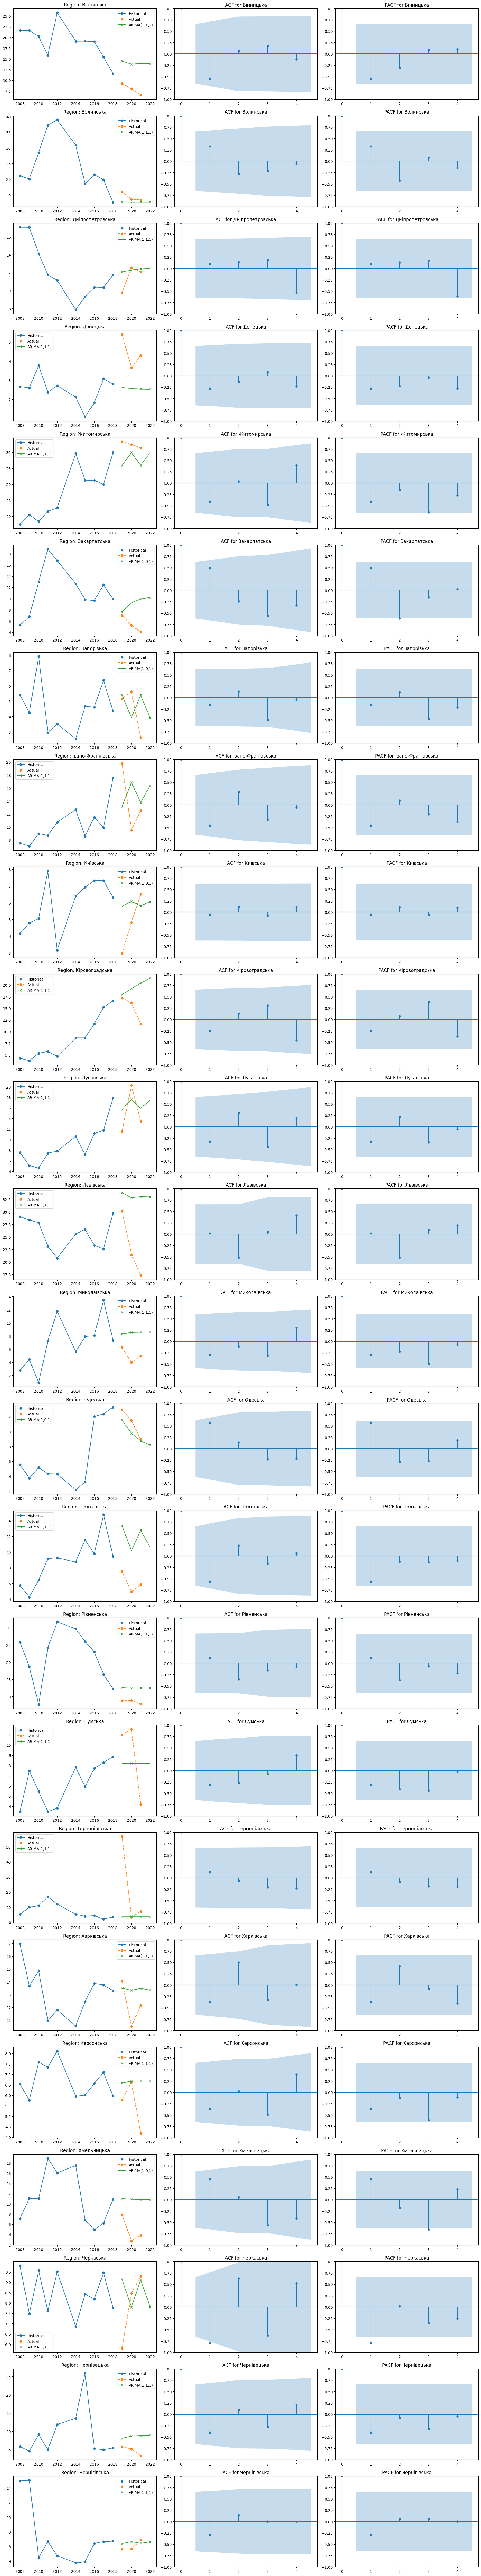

In [32]:
forecast_years = [2019, 2020, 2021, 2022]

regions = st_f_df['region'].unique()

def determine_arima_orders(series, d=1):
    adf_result = adfuller(series)
    if adf_result[1] < 0.05:  
        d = 0
    
    if d > 0:
        diff_series = np.diff(series, n=d)
    else:
        diff_series = series
    
    max_lags = min(4, len(diff_series)-1)
    
    return d, series, diff_series

fig = plt.figure(figsize=(18, 4*len(regions)))

for i, region in enumerate(regions):
    region_data = st_f_df[st_f_df['region'] == region].sort_values('year')
    
    train_data = region_data[region_data['year'] <= 2018]
    test_data = region_data[region_data['year'].isin(forecast_years)]
    
    y_train = train_data[variable_to_forecast].values
    
    d, original_series, diff_series = determine_arima_orders(y_train)
    
    ax1 = plt.subplot2grid((len(regions), 3), (i, 0))
    ax2 = plt.subplot2grid((len(regions), 3), (i, 1))
    ax3 = plt.subplot2grid((len(regions), 3), (i, 2))
    
    plot_acf(diff_series, lags=min(4, len(diff_series)-1), ax=ax2, title=f'ACF for {region}')
    plot_pacf(diff_series, lags=min(4, len(diff_series)-1), ax=ax3, title=f'PACF for {region}')
    
    p = 0
    q = 0
    
    best_aic = float('inf')
    best_order = (1, d, 1) 
    
    # TODO AIC criteria selection commented below, find methods to select p and q
    # for p_test in range(4):
    #     for q_test in range(4):
    #         try:
    #             model = ARIMA(y_train, order=(p_test, d, q_test))
    #             model_fit = model.fit()
    #             if model_fit.aic < best_aic:
    #                 best_aic = model_fit.aic
    #                 best_order = (p_test, d, q_test)
    #         except:
    #             continue
    
    p, d, q = best_order
    
    
    model = ARIMA(y_train, order=(p, d, q))
    model_fit = model.fit()
    
    forecast = model_fit.forecast(steps=len(forecast_years))
    
    if 'ax1' not in locals():
        ax1 = plt.subplot2grid((len(regions), 3), (i, 0))
        ax2 = plt.subplot2grid((len(regions), 3), (i, 1))
        ax3 = plt.subplot2grid((len(regions), 3), (i, 2))
        
        if len(y_train) >= 4:
            plot_acf(y_train, lags=min(10, len(y_train)-1), ax=ax2, title=f'ACF for {region}')
            plot_pacf(y_train, lags=min(10, len(y_train)-1), ax=ax3, title=f'PACF for {region}')
        else:
            ax2.text(0.5, 0.5, "Not enough data for ACF", 
                     horizontalalignment='center', verticalalignment='center')
            ax3.text(0.5, 0.5, "Not enough data for PACF", 
                     horizontalalignment='center', verticalalignment='center')
    
    ax1.plot(train_data['year'], train_data[variable_to_forecast], marker='o', label='Historical')
    
    if len(test_data) > 0:
        ax1.plot(test_data['year'], test_data[variable_to_forecast], marker='o', linestyle='--', label='Actual')
    
    ax1.plot(forecast_years, forecast, marker='x', label=f'ARIMA({p},{d},{q})')
    
    ax1.set_title(f'Region: {region}')
    ax1.legend()

plt.tight_layout()
plt.show()